# Transaction Classification using Naive Bayes Classifier

First manage all the imports and set the random seed for reproducibility:

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
from pylab import barh,plot,yticks,show,grid,xlabel,figure

np.random.seed(42)

Helper functions for data cleansing and plotting:

In [2]:
def read_float_with_comma(num):
    return float(num.replace(",", "."))

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = list(unique_labels(y_true, y_pred))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Load data into pandas dataframe:

In [3]:
df = pd.read_csv('Exercise 1 - Transaction Classification - Data Set.csv', sep=';')

Plot of the property 'Betrag', which showed that it does not really qualify as an input feature due to the similarites of the values for almost all classes:

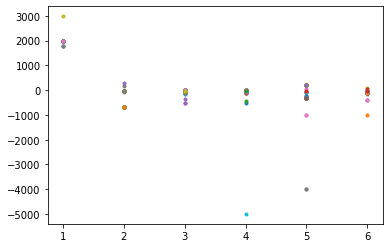

In [4]:
df['label']
labels={'income':1,'living':2,'leisure':3,'standardOfLiving':4,'finance':5,'private':6}

betrag = []
for ind, val in enumerate(df['Betrag']):
    plt.plot(labels[df['label'][ind]],read_float_with_comma(val),'.')
plt.show()

Preprocessing of the text data: 
    1. Extract relevant raw text from the dataframe. 
    2. Train/Test Split (75%/25%)
    3. Fitting the CountVectorizer to transform text data into numerical vectors

In [ ]:
#1.
text_data = []
labels = []
for text, empf, verw, label in zip(df['Buchungstext'],df['Beguenstigter/Zahlungspflichtiger'], df['Verwendungszweck'],df['label']):
    text_data.append(str(text) + ' ' + str(empf) + ' ' + str(verw))
    labels.append(str(label))
    
# 2.
X_train, X_test, Y_train, Y_test = train_test_split(zweck_all, labels)

# 3.
count = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b')
# token_pattern: regex to tokenize words who are seperated by '-' as on word
bag = count.fit_transform(X_train)
bag_test = count.transform(X_test)

Below, the machine learning part begins, with training of the classifier, than predicting the test set:

In [6]:
clf = MultinomialNB().fit(bag.toarray(), Y_train)
predicted = clf.predict(bag_test.toarray())

result = list(zip(predicted,Y_test))
i = 0
for val in result:
    if val[0] == val[1]:
        i+=1



Last cell shows the results of the task plotted as confusion matrix (Figure 1) and a classification report (Table 1). Furthermore, the result of a chi square test is plotted, see more details by reading the dedicated paper. 

Confusion matrix, without normalization
[[ 8  0  0  0  0  0]
 [ 0  4  0  0  0  0]
 [ 0  0 16  0  0  0]
 [ 0  0  0  5  0  2]
 [ 1  0  1  0  4  0]
 [ 0  0  1  0  0 11]]

Figure 1:


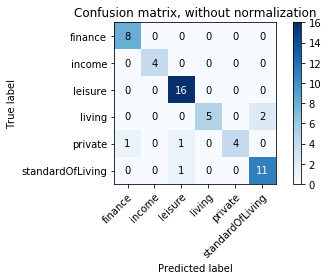


Table 1:
                  precision    recall  f1-score   support

         finance       0.89      1.00      0.94         8
          income       1.00      1.00      1.00         4
         leisure       0.89      1.00      0.94        16
          living       1.00      0.71      0.83         7
         private       1.00      0.67      0.80         6
standardOfLiving       0.85      0.92      0.88        12

        accuracy                           0.91        53
       macro avg       0.94      0.88      0.90        53
    weighted avg       0.91      0.91      0.90        53


Figure 2:


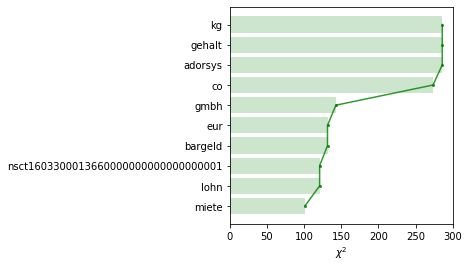

In [7]:
class_names = ['finance', 'income', 'leisure', 'living', 'private', 'standardOfLiving']

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, predicted, classes=class_names,
                      title='Confusion matrix, without normalization')

print('\nFigure 1:')
plt.show()

print('\nTable 1:')

# print classification report with f1 score
print(classification_report(Y_test, predicted, target_names=class_names))

print('\nFigure 2:')

# compute chi2 for each feature
chi2score = chi2(bag,Y_train)[0]

# plot 10 best chi2 scores
figure(figsize=(4,4))
wscores = zip(count.get_feature_names(),chi2score)
wchi2 = sorted(wscores,key=lambda x:x[1]) 
topchi2 = list(zip(*wchi2[-10:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
barh(x,topchi2[1],align='center',alpha=.2,color='g')
plot(topchi2[1],x,'-o',markersize=2,alpha=.8,color='g')
yticks(x,labels)
xlabel('$\chi^2$')
show()